In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, log_loss
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import joblib
import pyttsx3
import os
import re
from math import sqrt

In [5]:
# Define dataset paths and output folder
dataset_paths = [
    r"C:\DATA1\symptom_dataset\symptom_disease_dataset_balanced.csv",
    r"C:\DATA1\symptom_dataset\symptom_disease_dataset_imbalanced.csv",
    r"C:\DATA1\symptom_dataset\symptom_disease_dataset_large.csv"
]
dataset_names = ['Balanced (1000 samples)', 'Imbalanced (5000 samples)', 'Large Diverse (10000 samples)']
output_folder = r"C:\DATA1\symptom_dataset\models"

# Create output folder and verify
try:
    os.makedirs(output_folder, exist_ok=True)
    print(f"Output folder created or exists: {output_folder}")
except Exception as e:
    print(f"Error creating output folder {output_folder}: {e}")
    raise

# Verify dataset directory exists
dataset_dir = r"C:\DATA1\symptom_dataset"
if not os.path.exists(dataset_dir):
    print(f"Dataset directory {dataset_dir} does not exist. Please create it and add datasets.")
    raise FileNotFoundError(f"Directory {dataset_dir} not found")

Output folder created or exists: C:\DATA1\symptom_dataset\models


In [6]:

# Visualize data distribution (for Large Diverse dataset only)
def visualize_data_distribution(data, dataset_id):
    symptom_columns = ['Fever', 'Cough', 'Sneezing', 'Fatigue', 'Loss of Taste', 'Itchy Eyes']
    prevalence = data.groupby('Diagnosis')[symptom_columns].mean()
    
    # Symptom prevalence plot
    plt.figure(figsize=(12, 6))
    prevalence.plot(kind='bar', stacked=False)
    plt.title(f'Symptom Prevalence by Diagnosis - {dataset_id}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Mean Prevalence')
    plt.legend(title='Symptoms')
    plt.tight_layout()
    try:
        plt.savefig(os.path.join(output_folder, f'symptom_prevalence_{dataset_id}.png'))
        print(f"Saved symptom prevalence plot to {os.path.join(output_folder, f'symptom_prevalence_{dataset_id}.png')}")
    except Exception as e:
        print(f"Error saving symptom prevalence plot: {e}")
    plt.show()
    
    # Diagnosis distribution plot
    diagnosis_counts = data['Diagnosis'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Diagnosis Distribution - {dataset_id}')
    plt.tight_layout()
    try:
        plt.savefig(os.path.join(output_folder, f'diagnosis_distribution_{dataset_id}.png'))
        print(f"Saved diagnosis distribution plot to {os.path.join(output_folder, f'diagnosis_distribution_{dataset_id}.png')}")
    except Exception as e:
        print(f"Error saving diagnosis distribution plot: {e}")
    plt.show()

# Function to compute MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    if np.sum(non_zero) == 0:
        return np.nan
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100


In [ ]:
# Function to train and evaluate Random Forest
def train_rf(X_train, X_test, y_train, y_test, y_test_one_hot, dataset_id):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_pred_probs = rf_model.predict_proba(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_f1 = f1_score(y_test, rf_pred, average='weighted')
    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_mse = mean_squared_error(y_test, rf_pred)
    rf_rmse = sqrt(rf_mse)
    rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
    rf_loss = log_loss(y_test, rf_pred_probs)
    
    try:
        joblib.dump(rf_model, os.path.join(output_folder, f'rf_model_{dataset_id}.pkl'))
        print(f"Saved Random Forest model to {os.path.join(output_folder, f'rf_model_{dataset_id}.pkl')}")
    except Exception as e:
        print(f"Error saving Random Forest model for {dataset_id}: {e}")
        raise
    return rf_model, rf_accuracy, rf_f1, rf_mae, rf_mse, rf_rmse, rf_mape, rf_loss

In [8]:
# Function to train and evaluate Fully Connected Neural Network
def train_fc(X_train_dl, X_test_dl, y_train_dl, y_test, y_test_one_hot, X, label_encoder, dataset_id):
    def build_fc_model():
        inputs = tf.keras.Input(shape=(X.shape[1],))
        x = layers.Dense(64, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x, training=True)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x, training=True)
        x = layers.Dense(16, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x, training=True)
        outputs = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)
        return tf.keras.Model(inputs, outputs)
    
    fc_model = build_fc_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    fc_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    history = fc_model.fit(X_train_dl, y_train_dl, epochs=50, batch_size=32, verbose=1, 
                          validation_split=0.2, callbacks=[lr_scheduler])
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'FCNN Loss - {dataset_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'FCNN Accuracy - {dataset_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    try:
        plt.savefig(os.path.join(output_folder, f'fcnn_training_plot_{dataset_id}.png'))
        print(f"Saved FCNN training plot to {os.path.join(output_folder, f'fcnn_training_plot_{dataset_id}.png')}")
    except Exception as e:
        print(f"Error saving FCNN training plot for {dataset_id}: {e}")
    plt.show()
    
    fc_pred_probs = fc_model.predict(X_test_dl, verbose=0)
    fc_pred = np.argmax(fc_pred_probs, axis=1)
    fc_accuracy = accuracy_score(y_test, fc_pred)
    fc_f1 = f1_score(y_test, fc_pred, average='weighted')
    fc_mae = mean_absolute_error(y_test, fc_pred)
    fc_mse = mean_squared_error(y_test, fc_pred)
    fc_rmse = sqrt(fc_mse)
    fc_mape = mean_absolute_percentage_error(y_test, fc_pred)
    fc_loss = log_loss(y_test, fc_pred_probs)
    
    try:
        fc_model.save(os.path.join(output_folder, f'fc_model_{dataset_id}.h5'))
        print(f"Saved Fully Connected model to {os.path.join(output_folder, f'fc_model_{dataset_id}.h5')}")
    except Exception as e:
        print(f"Error saving Fully Connected model for {dataset_id}: {e}")
        raise
    return fc_model, fc_accuracy, fc_f1, fc_mae, fc_mse, fc_rmse, fc_mape, fc_loss, history

In [9]:
# Function to train and evaluate RNN
def train_rnn(X_train_rnn, X_test_rnn, y_train_dl, y_test, y_test_one_hot, label_encoder, dataset_id):
    def build_rnn_model():
        inputs = tf.keras.Input(shape=(6, 1))
        x = layers.LSTM(32, activation='relu', return_sequences=False)(inputs)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)
        return tf.keras.Model(inputs, outputs)
    
    rnn_model = build_rnn_model()
    rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = rnn_model.fit(X_train_rnn, y_train_dl, epochs=50, batch_size=32, verbose=1, validation_split=0.2)
    
    # Plot RNN training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'RNN Loss - {dataset_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'RNN Accuracy - {dataset_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    try:
        plt.savefig(os.path.join(output_folder, f'rnn_training_plot_{dataset_id}.png'))
        print(f"Saved RNN training plot to {os.path.join(output_folder, f'rnn_training_plot_{dataset_id}.png')}")
    except Exception as e:
        print(f"Error saving RNN training plot for {dataset_id}: {e}")
    plt.show()
    
    rnn_pred_probs = rnn_model.predict(X_test_rnn, verbose=0)
    rnn_pred = np.argmax(rnn_pred_probs, axis=1)
    rnn_accuracy = accuracy_score(y_test, rnn_pred)
    rnn_f1 = f1_score(y_test, rnn_pred, average='weighted')
    rnn_mae = mean_absolute_error(y_test, rnn_pred)
    rnn_mse = mean_squared_error(y_test, rnn_pred)
    rnn_rmse = sqrt(rnn_mse)
    rnn_mape = mean_absolute_percentage_error(y_test, rnn_pred)
    rnn_loss = log_loss(y_test, rnn_pred_probs)
    
    try:
        rnn_model.save(os.path.join(output_folder, f'rnn_model_{dataset_id}.h5'))
        print(f"Saved RNN model to {os.path.join(output_folder, f'rnn_model_{dataset_id}.h5')}")
    except Exception as e:
        print(f"Error saving RNN model for {dataset_id}: {e}")
        raise
    return rnn_model, rnn_accuracy, rnn_f1, rnn_mae, rnn_mse, rnn_rmse, rnn_mape, rnn_loss


In [11]:
# Function to train and evaluate CNN
def train_cnn(X_train_cnn, X_test_cnn, y_train_dl, y_test, y_test_one_hot, label_encoder, dataset_id):
    def build_cnn_model():
        inputs = tf.keras.Input(shape=(6, 1))
        x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)
        return tf.keras.Model(inputs, outputs)
    
    cnn_model = build_cnn_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    history = cnn_model.fit(X_train_cnn, y_train_dl, epochs=50, batch_size=32, verbose=1, 
                           validation_split=0.2, callbacks=[lr_scheduler])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'CNN Loss - {dataset_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'CNN Accuracy - {dataset_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    try:
        plt.savefig(os.path.join(output_folder, f'cnn_training_plot_{dataset_id}.png'))
        print(f"Saved CNN training plot to {os.path.join(output_folder, f'cnn_training_plot_{dataset_id}.png')}")
    except Exception as e:
        print(f"Error saving CNN training plot for {dataset_id}: {e}")
    plt.show()
    
    cnn_pred_probs = cnn_model.predict(X_test_cnn, verbose=0)
    cnn_pred = np.argmax(cnn_pred_probs, axis=1)
    cnn_accuracy = accuracy_score(y_test, cnn_pred)
    cnn_f1 = f1_score(y_test, cnn_pred, average='weighted')
    cnn_mae = mean_absolute_error(y_test, cnn_pred)
    cnn_mse = mean_squared_error(y_test, cnn_pred)
    cnn_rmse = sqrt(cnn_mse)
    cnn_mape = mean_absolute_percentage_error(y_test, cnn_pred)
    cnn_loss = log_loss(y_test, cnn_pred_probs)
    
    try:
        cnn_model.save(os.path.join(output_folder, f'cnn_model_{dataset_id}.h5'))
        print(f"Saved CNN model to {os.path.join(output_folder, f'cnn_model_{dataset_id}.h5')}")
    except Exception as e:
        print(f"Error saving CNN model for {dataset_id}: {e}")
        raise
    return cnn_model, cnn_accuracy, cnn_f1, cnn_mae, cnn_mse, cnn_rmse, cnn_mape, cnn_loss

In [10]:
# Function to plot model comparison
def plot_model_comparison(results, dataset_id, metrics=['Accuracy', 'F1-Score', 'MAE', 'MSE', 'RMSE', 'MAPE', 'Loss']):
    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 4, i+1)
        sns.barplot(x='Model', y=metric, data=results)
        plt.title(f'{metric} Comparison')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
    plt.tight_layout()
    try:
        plt.savefig(os.path.join(output_folder, f'model_metrics_comparison_{dataset_id}.png'))
        print(f"Saved model metrics comparison plot to {os.path.join(output_folder, f'model_metrics_comparison_{dataset_id}.png')}")
    except Exception as e:
        print(f"Error saving model metrics comparison plot: {e}")
    plt.show()

# Function to parse symptoms from text
def parse_symptoms(text):
    symptom_map = {
        'Fever': ['fever', 'high temperature', 'hot'],
        'Cough': ['cough', 'coughing'],
        'Sneezing': ['sneeze', 'sneezing'],
        'Fatigue': ['fatigue', 'tired', 'exhausted'],
        'Loss of Taste': ['loss of taste', 'no taste', 'taste loss', 'lost my sense of taste'],
        'Itchy Eyes': ['itchy eyes', 'eye itch', 'eyes itching']
    }
    symptoms = [0] * 6  # [Fever, Cough, Sneezing, Fatigue, Loss of Taste, Itchy Eyes]
    text = text.lower()
    
    for i, (symptom, keywords) in enumerate(symptom_map.items()):
        for keyword in keywords:
            if keyword in text:
                symptoms[i] = 1
                print(f"Matched symptom '{symptom}' with keyword '{keyword}'")
                break
    
    return symptoms


Processing Balanced (1000 samples)...
Saved Random Forest model to C:\DATA1\symptom_dataset\models\rf_model_balanced_1000_samples.pkl
Epoch 1/50
20/20 [==============================] - 2s 13ms/step - loss: 1.7628 - accuracy: 0.2937 - val_loss: 1.3744 - val_accuracy: 0.3375 - lr: 5.0000e-04
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 1.6118 - accuracy: 0.3594 - val_loss: 1.3713 - val_accuracy: 0.3313 - lr: 5.0000e-04
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 1.4999 - accuracy: 0.4016 - val_loss: 1.3800 - val_accuracy: 0.2937 - lr: 5.0000e-04
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 1.3995 - accuracy: 0.4250 - val_loss: 1.3558 - val_accuracy: 0.3063 - lr: 5.0000e-04
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 1.3757 - accuracy: 0.4297 - val_loss: 1.3299 - val_accuracy: 0.3500 - lr: 5.0000e-04
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 1.2870 

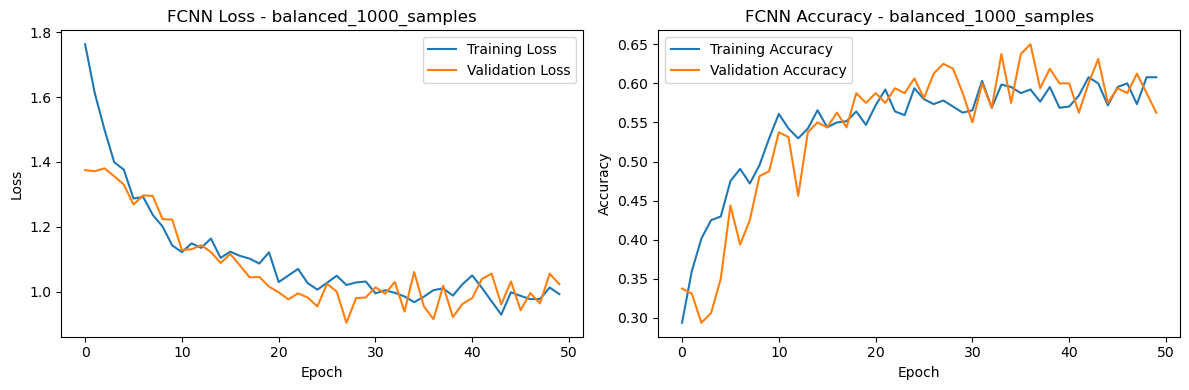

Saved Fully Connected model to C:\DATA1\symptom_dataset\models\fc_model_balanced_1000_samples.h5
Epoch 1/50
20/20 [==============================] - 1s 12ms/step - loss: 1.3854 - accuracy: 0.2406 - val_loss: 1.3828 - val_accuracy: 0.1562
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 1.3818 - accuracy: 0.2625 - val_loss: 1.3807 - val_accuracy: 0.2438
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 1.3792 - accuracy: 0.2969 - val_loss: 1.3778 - val_accuracy: 0.2438
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 1.3764 - accuracy: 0.3125 - val_loss: 1.3735 - val_accuracy: 0.2625
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 1.3724 - accuracy: 0.2953 - val_loss: 1.3674 - val_accuracy: 0.2562
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 1.3598 - accuracy: 0.2859 - val_loss: 1.3551 - val_accuracy: 0.2688
Epoch 7/50
20/20 [==============================] - 0s 3ms/ste

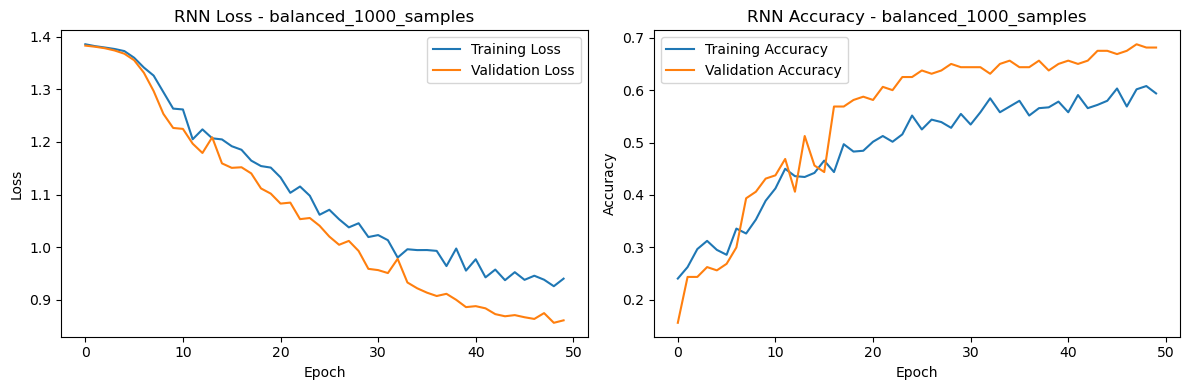

Saved RNN model to C:\DATA1\symptom_dataset\models\rnn_model_balanced_1000_samples.h5
Epoch 1/50
20/20 [==============================] - 1s 10ms/step - loss: 1.8820 - accuracy: 0.3125 - val_loss: 1.3813 - val_accuracy: 0.2438 - lr: 5.0000e-04
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 1.4683 - accuracy: 0.3516 - val_loss: 1.3727 - val_accuracy: 0.2875 - lr: 5.0000e-04
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 1.2734 - accuracy: 0.3859 - val_loss: 1.3696 - val_accuracy: 0.3375 - lr: 5.0000e-04
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 1.1635 - accuracy: 0.4719 - val_loss: 1.3689 - val_accuracy: 0.3688 - lr: 5.0000e-04
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 1.1128 - accuracy: 0.5000 - val_loss: 1.3695 - val_accuracy: 0.4313 - lr: 5.0000e-04
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 1.0800 - accuracy: 0.5531 - val_loss: 1.3612 - val_accur

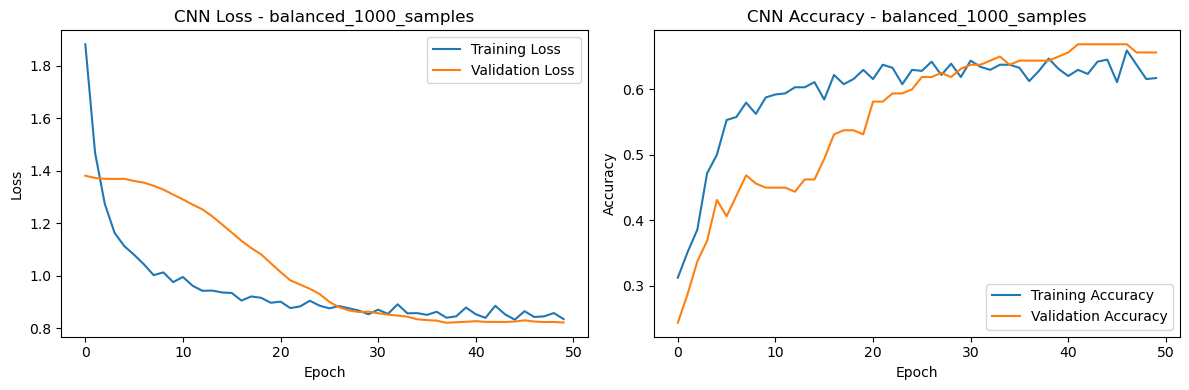

Saved CNN model to C:\DATA1\symptom_dataset\models\cnn_model_balanced_1000_samples.h5
Saved label encoder to C:\DATA1\symptom_dataset\models\label_encoder_balanced_1000_samples.pkl
Saved model metrics comparison plot to C:\DATA1\symptom_dataset\models\model_metrics_comparison_balanced_1000_samples.png


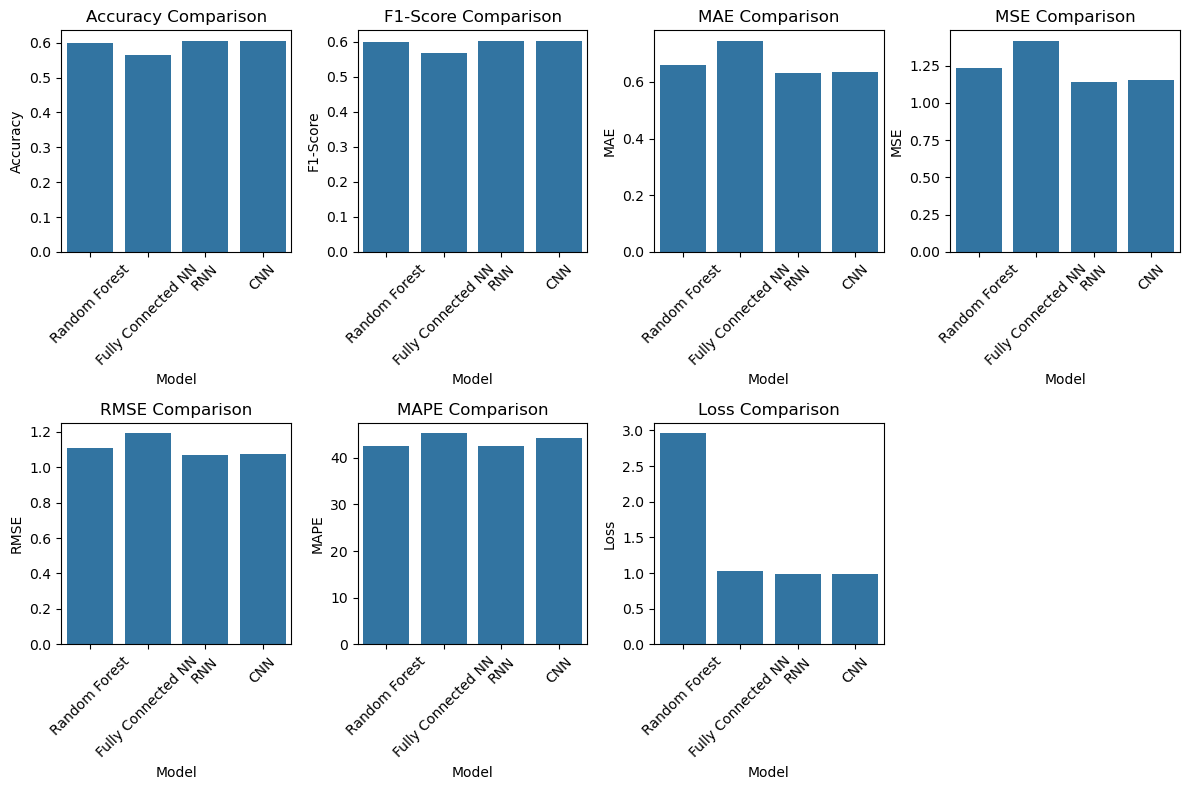


Model Comparison for Balanced (1000 samples):
                Model  Accuracy  F1-Score    MAE    MSE      RMSE       MAPE  \
0       Random Forest     0.600  0.600270  0.660  1.230  1.109054  42.393736   
1  Fully Connected NN     0.565  0.567806  0.745  1.415  1.189538  45.190157   
2                 RNN     0.605  0.602972  0.630  1.140  1.067708  42.505593   
3                 CNN     0.605  0.602450  0.635  1.155  1.074709  44.295302   

       Loss  
0  2.957998  
1  1.033053  
2  0.987230  
3  0.990246  

Processing Imbalanced (5000 samples)...
Saved Random Forest model to C:\DATA1\symptom_dataset\models\rf_model_imbalanced_5000_samples.pkl
Epoch 1/50
100/100 [==============================] - 1s 3ms/step - loss: 1.7126 - accuracy: 0.3438 - val_loss: 1.3104 - val_accuracy: 0.3812 - lr: 5.0000e-04
Epoch 2/50
100/100 [==============================] - 0s 2ms/step - loss: 1.3842 - accuracy: 0.4594 - val_loss: 1.2165 - val_accuracy: 0.4563 - lr: 5.0000e-04
Epoch 3/50
100/100 [=====

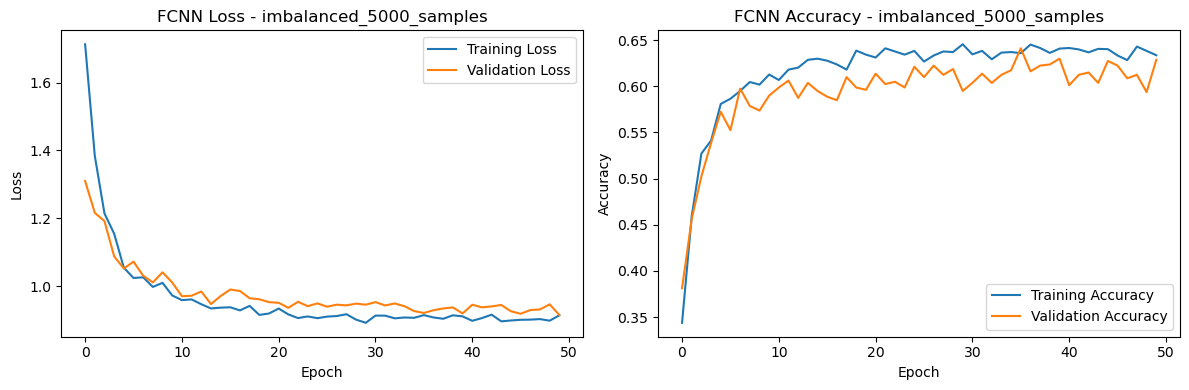

Saved Fully Connected model to C:\DATA1\symptom_dataset\models\fc_model_imbalanced_5000_samples.h5
Epoch 1/50
100/100 [==============================] - 1s 4ms/step - loss: 1.3179 - accuracy: 0.3928 - val_loss: 1.2638 - val_accuracy: 0.4062
Epoch 2/50
100/100 [==============================] - 0s 2ms/step - loss: 1.2485 - accuracy: 0.4022 - val_loss: 1.2278 - val_accuracy: 0.4150
Epoch 3/50
100/100 [==============================] - 0s 2ms/step - loss: 1.2176 - accuracy: 0.4291 - val_loss: 1.1982 - val_accuracy: 0.4412
Epoch 4/50
100/100 [==============================] - 0s 2ms/step - loss: 1.1927 - accuracy: 0.4316 - val_loss: 1.1623 - val_accuracy: 0.4863
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 1.1599 - accuracy: 0.4603 - val_loss: 1.1390 - val_accuracy: 0.4787
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 1.1348 - accuracy: 0.5103 - val_loss: 1.1050 - val_accuracy: 0.5300
Epoch 7/50
100/100 [=============================

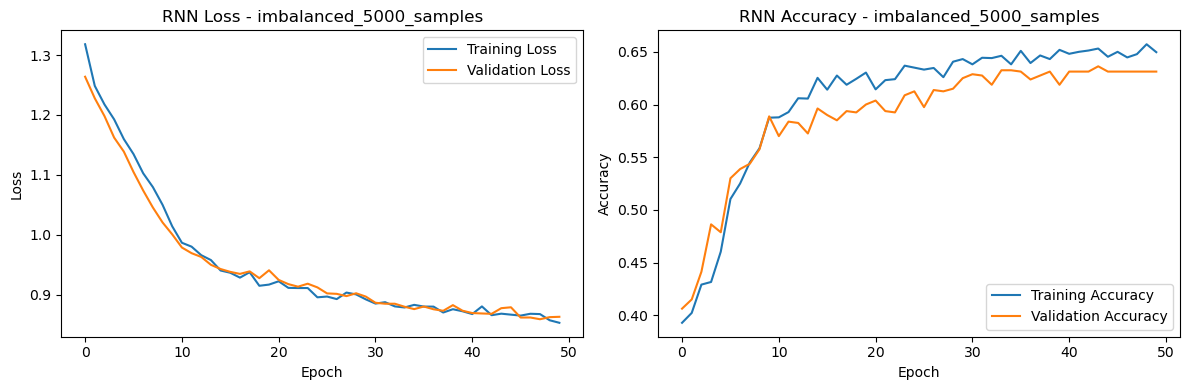

Saved RNN model to C:\DATA1\symptom_dataset\models\rnn_model_imbalanced_5000_samples.h5
Epoch 1/50
100/100 [==============================] - 1s 3ms/step - loss: 1.2731 - accuracy: 0.4691 - val_loss: 1.3142 - val_accuracy: 0.4263 - lr: 5.0000e-04
Epoch 2/50
100/100 [==============================] - 0s 2ms/step - loss: 1.0159 - accuracy: 0.5763 - val_loss: 1.2327 - val_accuracy: 0.5263 - lr: 5.0000e-04
Epoch 3/50
100/100 [==============================] - 0s 2ms/step - loss: 0.9664 - accuracy: 0.5972 - val_loss: 1.0971 - val_accuracy: 0.5775 - lr: 5.0000e-04
Epoch 4/50
100/100 [==============================] - 0s 2ms/step - loss: 0.9406 - accuracy: 0.6228 - val_loss: 1.0126 - val_accuracy: 0.6137 - lr: 5.0000e-04
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 0.9481 - accuracy: 0.6178 - val_loss: 0.9404 - val_accuracy: 0.6237 - lr: 5.0000e-04
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 0.9243 - accuracy: 0.6250 - val_loss: 0.902

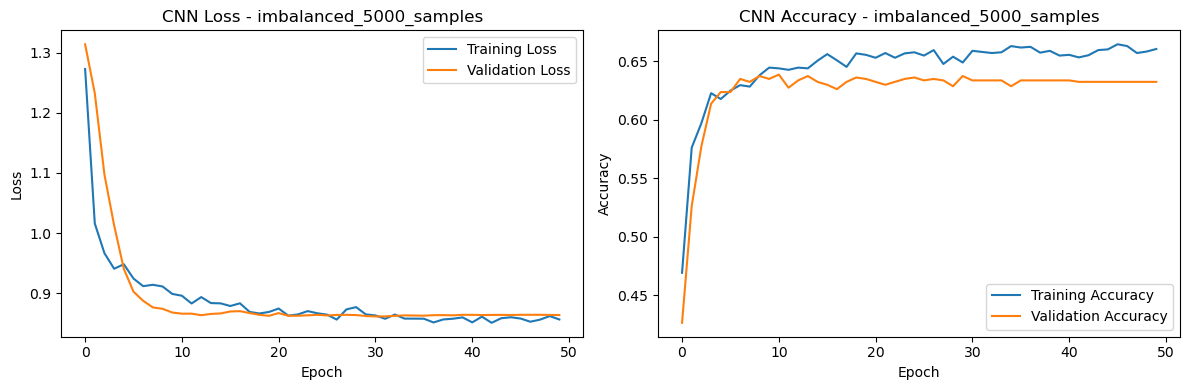

Saved CNN model to C:\DATA1\symptom_dataset\models\cnn_model_imbalanced_5000_samples.h5
Saved label encoder to C:\DATA1\symptom_dataset\models\label_encoder_imbalanced_5000_samples.pkl
Saved model metrics comparison plot to C:\DATA1\symptom_dataset\models\model_metrics_comparison_imbalanced_5000_samples.png


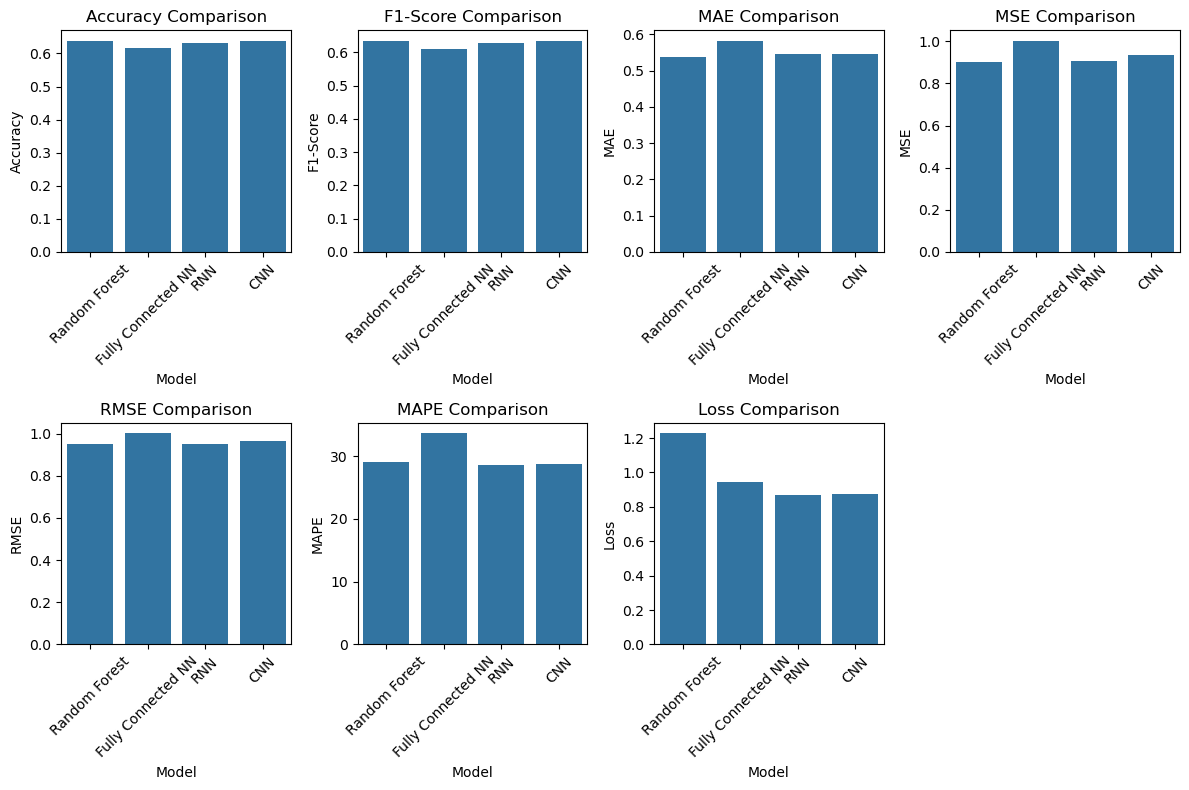


Model Comparison for Imbalanced (5000 samples):
                Model  Accuracy  F1-Score    MAE    MSE      RMSE       MAPE  \
0       Random Forest     0.638  0.634712  0.538  0.902  0.949737  29.000000   
1  Fully Connected NN     0.617  0.611142  0.582  1.002  1.001000  33.629630   
2                 RNN     0.631  0.627014  0.545  0.907  0.952365  28.518519   
3                 CNN     0.638  0.632898  0.547  0.935  0.966954  28.703704   

       Loss  
0  1.227200  
1  0.942928  
2  0.866463  
3  0.872521  

Processing Large Diverse (10000 samples)...
Saved symptom prevalence plot to C:\DATA1\symptom_dataset\models\symptom_prevalence_large_diverse_10000_samples.png


<Figure size 1200x600 with 0 Axes>

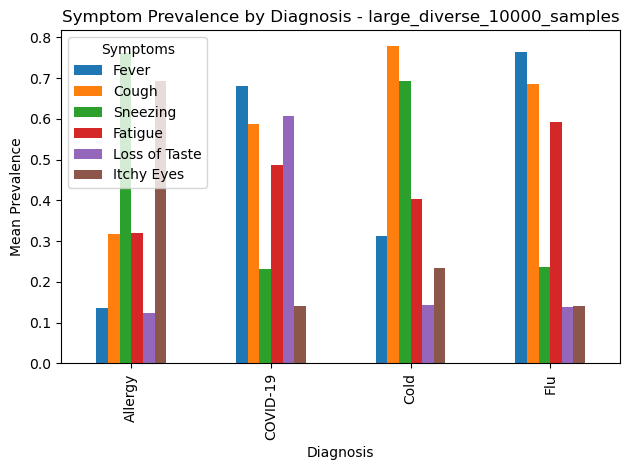

Saved diagnosis distribution plot to C:\DATA1\symptom_dataset\models\diagnosis_distribution_large_diverse_10000_samples.png


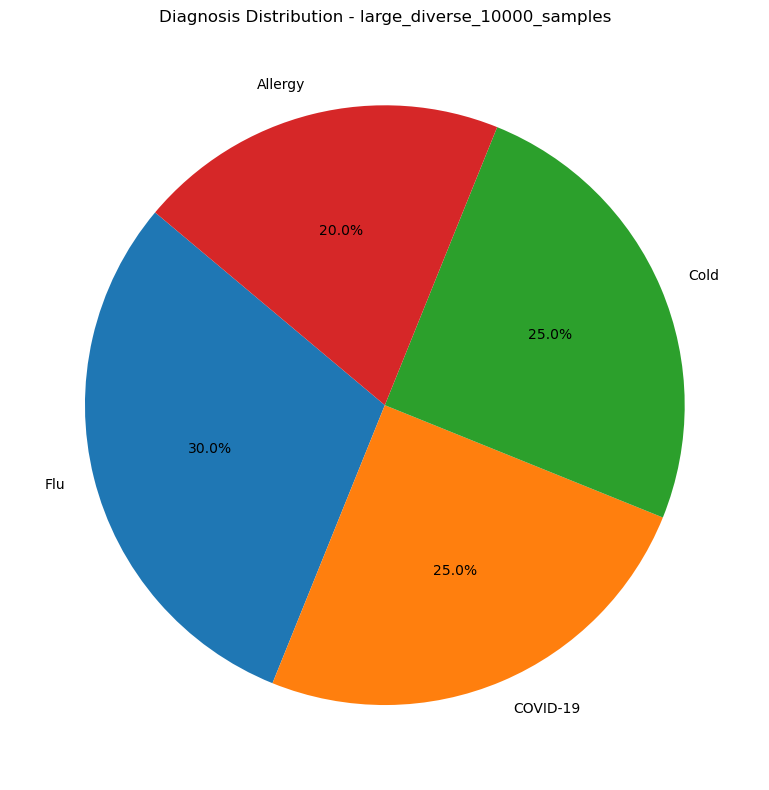

Saved Random Forest model to C:\DATA1\symptom_dataset\models\rf_model_large_diverse_10000_samples.pkl
Epoch 1/50
200/200 [==============================] - 1s 2ms/step - loss: 1.6352 - accuracy: 0.3483 - val_loss: 1.2746 - val_accuracy: 0.4025 - lr: 5.0000e-04
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 1.2609 - accuracy: 0.4781 - val_loss: 1.1462 - val_accuracy: 0.4969 - lr: 5.0000e-04
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 1.1791 - accuracy: 0.4981 - val_loss: 1.1240 - val_accuracy: 0.5138 - lr: 5.0000e-04
Epoch 4/50
200/200 [==============================] - 0s 1ms/step - loss: 1.1206 - accuracy: 0.5286 - val_loss: 1.1073 - val_accuracy: 0.5219 - lr: 5.0000e-04
Epoch 5/50
200/200 [==============================] - 0s 1ms/step - loss: 1.1010 - accuracy: 0.5319 - val_loss: 1.0705 - val_accuracy: 0.5425 - lr: 5.0000e-04
Epoch 6/50
200/200 [==============================] - 0s 1ms/step - loss: 1.0766 - accuracy: 0.5467 - v

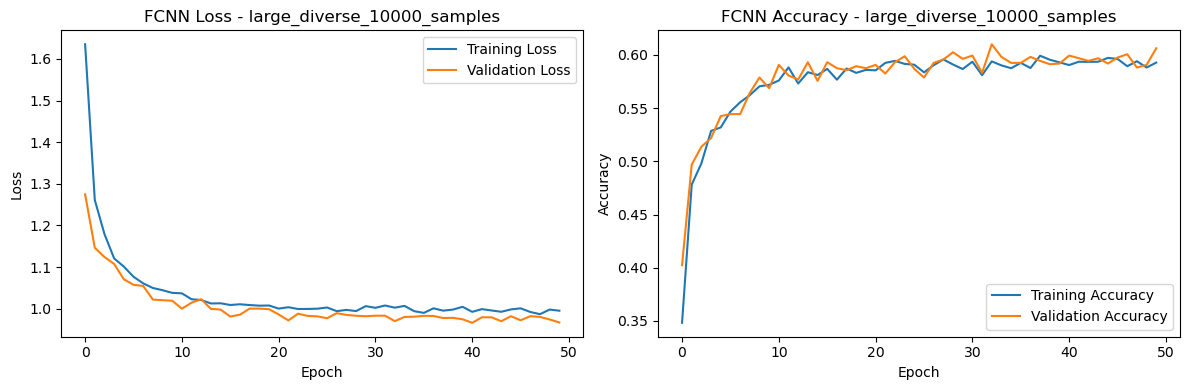

Saved Fully Connected model to C:\DATA1\symptom_dataset\models\fc_model_large_diverse_10000_samples.h5
Epoch 1/50
200/200 [==============================] - 1s 3ms/step - loss: 1.3692 - accuracy: 0.3056 - val_loss: 1.3315 - val_accuracy: 0.3231
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 1.2745 - accuracy: 0.4044 - val_loss: 1.2192 - val_accuracy: 0.4913
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 1.2193 - accuracy: 0.4459 - val_loss: 1.1772 - val_accuracy: 0.5263
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 1.1817 - accuracy: 0.4797 - val_loss: 1.1227 - val_accuracy: 0.5312
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 1.1294 - accuracy: 0.5114 - val_loss: 1.0703 - val_accuracy: 0.5694
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 1.0893 - accuracy: 0.5302 - val_loss: 1.0355 - val_accuracy: 0.5781
Epoch 7/50
200/200 [=========================

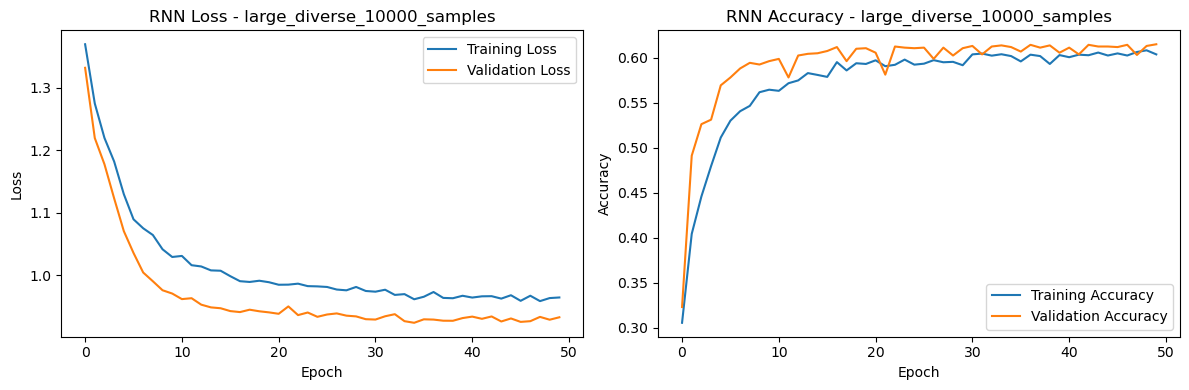

Saved RNN model to C:\DATA1\symptom_dataset\models\rnn_model_large_diverse_10000_samples.h5
Epoch 1/50
200/200 [==============================] - 1s 3ms/step - loss: 1.2574 - accuracy: 0.4512 - val_loss: 1.2631 - val_accuracy: 0.3581 - lr: 5.0000e-04
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 1.0748 - accuracy: 0.5453 - val_loss: 1.0707 - val_accuracy: 0.5869 - lr: 5.0000e-04
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 1.0466 - accuracy: 0.5636 - val_loss: 0.9743 - val_accuracy: 0.6100 - lr: 5.0000e-04
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 1.0202 - accuracy: 0.5844 - val_loss: 0.9521 - val_accuracy: 0.6144 - lr: 5.0000e-04
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 1.0180 - accuracy: 0.5853 - val_loss: 0.9471 - val_accuracy: 0.6144 - lr: 5.0000e-04
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 1.0076 - accuracy: 0.5980 - val_loss: 0

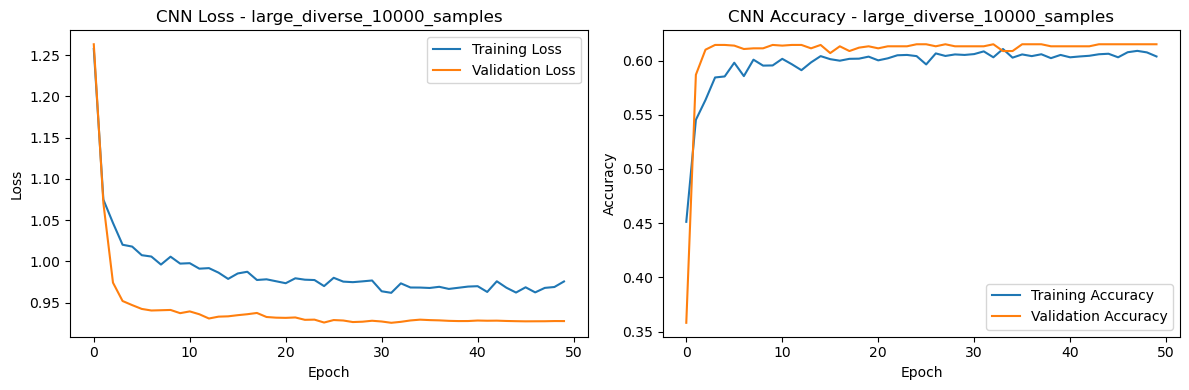

Saved CNN model to C:\DATA1\symptom_dataset\models\cnn_model_large_diverse_10000_samples.h5
Saved label encoder to C:\DATA1\symptom_dataset\models\label_encoder_large_diverse_10000_samples.pkl
Saved model metrics comparison plot to C:\DATA1\symptom_dataset\models\model_metrics_comparison_large_diverse_10000_samples.png


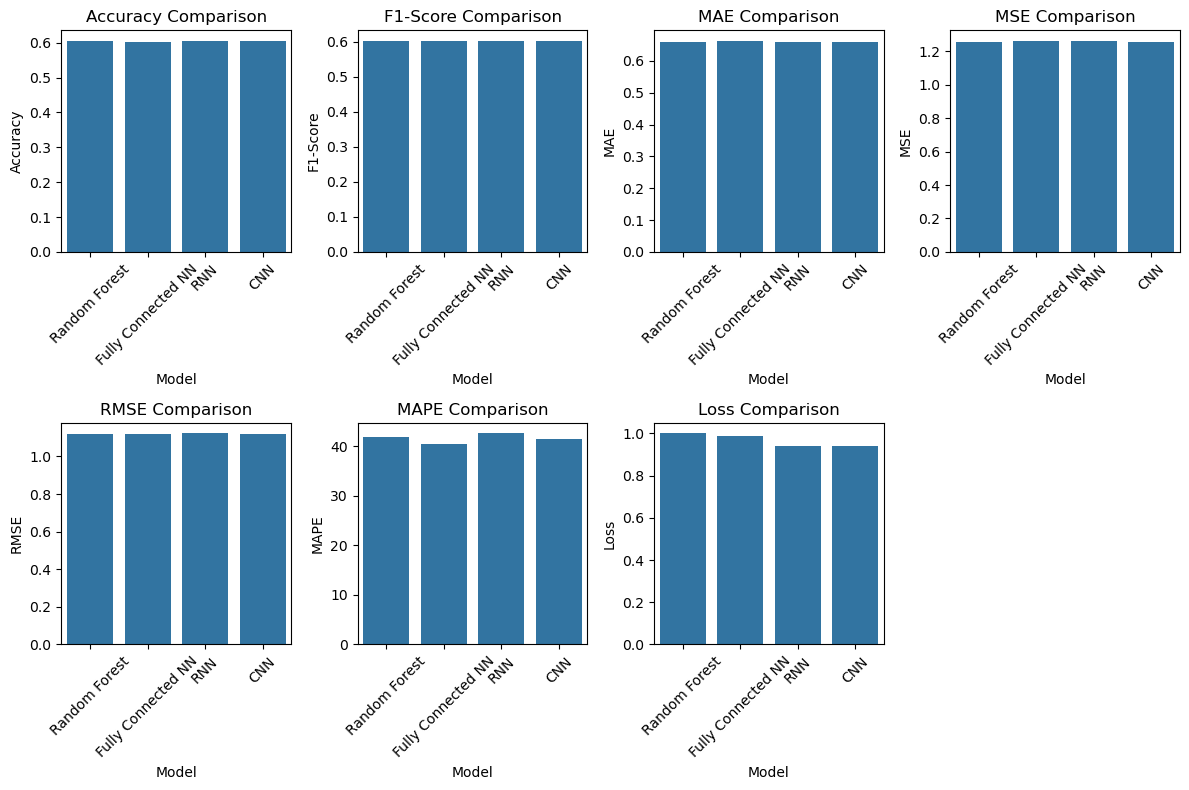


Model Comparison for Large Diverse (10000 samples):
                Model  Accuracy  F1-Score    MAE    MSE      RMSE       MAPE  \
0       Random Forest    0.6045  0.602445  0.660  1.257  1.121160  41.835017   
1  Fully Connected NN    0.6020  0.601592  0.663  1.259  1.122052  40.498737   
2                 RNN    0.6050  0.601857  0.661  1.261  1.122943  42.645202   
3                 CNN    0.6040  0.602592  0.660  1.255  1.120268  41.582492   

       Loss  
0  1.000158  
1  0.988080  
2  0.939521  
3  0.938593  


In [ ]:
# Process each dataset
fc_model_large = None
cnn_model_large = None
label_encoder_large = None
for dataset_path, dataset_name in zip(dataset_paths, dataset_names):
    print(f"\nProcessing {dataset_name}...")
    
    # Load and preprocess the dataset
    data = pd.read_csv(dataset_path)
    X = data.drop('Diagnosis', axis=1)
    y = data['Diagnosis']
    
    # Visualize data distribution for Large Diverse dataset
    dataset_id = dataset_name.lower().replace(' ', '_').replace('(', '').replace(')', '')
    if dataset_name == 'Large Diverse (10000 samples)':
        visualize_data_distribution(data, dataset_id)
    
    # Encode target labels  
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_one_hot = tf.keras.utils.to_categorical(y_encoded)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
    
    # Reshape for RNN
    X_train_rnn = X_train_dl.values.reshape(-1, 6, 1)
    X_test_rnn = X_test_dl.values.reshape(-1, 6, 1)
    X_train_cnn = X_train_rnn  # Same shape as RNN
    X_test_cnn = X_test_rnn
    
    # Train and evaluate each model
    rf_model, rf_accuracy, rf_f1, rf_mae, rf_mse, rf_rmse, rf_mape, rf_loss = train_rf(
        X_train, X_test, y_train, y_test, y_test_dl, dataset_id)
    fc_model, fc_accuracy, fc_f1, fc_mae, fc_mse, fc_rmse, fc_mape, fc_loss, fc_history = train_fc(
        X_train_dl, X_test_dl, y_train_dl, y_test, y_test_dl, X, label_encoder, dataset_id)
    rnn_model, rnn_accuracy, rnn_f1, rnn_mae, rnn_mse, rnn_rmse, rnn_mape, rnn_loss = train_rnn(
        X_train_rnn, X_test_rnn, y_train_dl, y_test, y_test_dl, label_encoder, dataset_id)
    cnn_model, cnn_accuracy, cnn_f1, cnn_mae, cnn_mse, cnn_rmse, cnn_mape, cnn_loss = train_cnn(
        X_train_cnn, X_test_cnn, y_train_dl, y_test, y_test_dl, label_encoder, dataset_id)
    
    # Save label encoder
    try:
        joblib.dump(label_encoder, os.path.join(output_folder, f'label_encoder_{dataset_id}.pkl'))
        print(f"Saved label encoder to {os.path.join(output_folder, f'label_encoder_{dataset_id}.pkl')}")
    except Exception as e:
        print(f"Error saving label encoder for {dataset_id}: {e}")
        raise
    
    # Store Fully Connected model and label encoder for large dataset
    if dataset_name == 'Large Diverse (10000 samples)':
        fc_model_large = fc_model
        cnn_model_large = cnn_model
        label_encoder_large = label_encoder
    
    # Collect results
    results = pd.DataFrame({
        'Model': ['Random Forest', 'Fully Connected NN', 'RNN', 'CNN'],
        'Accuracy': [rf_accuracy, fc_accuracy, rnn_accuracy, cnn_accuracy],
        'F1-Score': [rf_f1, fc_f1, rnn_f1, cnn_f1],
        'MAE': [rf_mae, fc_mae, rnn_mae, cnn_mae],
        'MSE': [rf_mse, fc_mse, rnn_mse, cnn_mse],
        'RMSE': [rf_rmse, fc_rmse, rnn_rmse, cnn_rmse],
        'MAPE': [rf_mape, fc_mape, rnn_mape, cnn_mape],
        'Loss': [rf_loss, fc_loss, rnn_loss, cnn_loss]
    })
    
    # Plot model comparison
    plot_model_comparison(results, dataset_id)
    
    print(f"\nModel Comparison for {dataset_name}:")
    print(results)

     Hello! I am your virtual health assistant robot.
Using RNN model.
Please describe your symptoms (e.g., 'I have a fever and cough') or type 'ask' to answer Y/N questions:

No symptoms detected in your description. Falling back to Y/N questions.

Please answer the following questions with Y/N:
Symptom vector: [0, 1, 1, 0, 1, 1]

     Diagnosis with Probabilities and Uncertainty:
Allergy: P=0.546, Uncertainty=0.126
COVID-19: P=0.075, Uncertainty=0.062
Cold: P=0.358, Uncertainty=0.093
Flu: P=0.020, Uncertainty=0.025

         Diagnosis: Allergy (±0.126)
   Test: Allergy skin test
   Medicine: Loratadine or Cetirizine


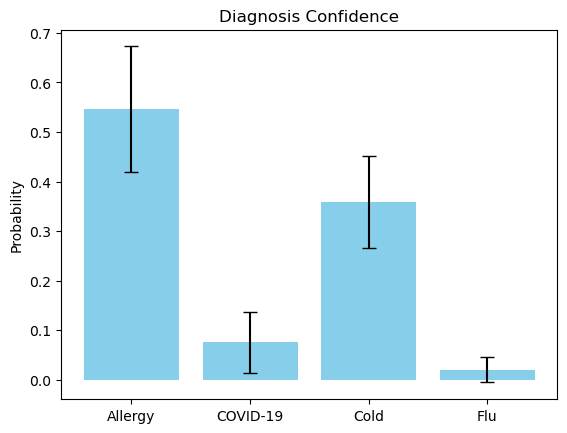

In [13]:
# Speak function
def speak(text):
    try:
        engine = pyttsx3.init()
        engine.say(text)
        engine.runAndWait()
    except Exception as e:
        print(f"Speech error: {e}")

# Prediction with uncertainty
# def predict_with_uncertainty(model, x, n_iter=100, is_rnn=False):
#     if is_rnn:
#         x = x.reshape(-1, 6, 1)
#     preds = np.array([model(x, training=True).numpy() for _ in range(n_iter)])
#     mean = preds.mean(axis=0)
#     std = preds.std(axis=0)
#     return mean, std
def predict_with_uncertainty(model, x, n_iter=100, is_rnn=False, is_cnn=False):
    if is_rnn or is_cnn:
        x = x.reshape(-1, 6, 1)
    preds = np.array([model(x, training=True).numpy() for _ in range(n_iter)])
    mean = preds.mean(axis=0)
    std = preds.std(axis=0)
    return mean, std

# Run virtual robot (with option to use RNN)
def run_virtual_robot(use_rnn=False,use_cnn=False):
    print("     Hello! I am your virtual health assistant robot.")
    print(f"Using {'RNN' if use_rnn else 'Fully Connected NN'} model.")
    print("Please describe your symptoms (e.g., 'I have a fever and cough') or type 'ask' to answer Y/N questions:")
    
    # Load model
    if use_rnn:
        model = tf.keras.models.load_model(os.path.join(output_folder, 'rnn_model_large_diverse_10000_samples.h5'))
    elif use_cnn:
        model_name = 'CNN'
    else:
        model = fc_model_large
    
    user_input = input("Your symptoms: ").strip().lower()
    symptom_names = ["Fever", "Cough", "Sneezing", "Fatigue", "Loss of Taste", "Itchy Eyes"]
    input_symptoms = None
    
    if user_input != 'ask':
        input_symptoms = parse_symptoms(user_input)
        if sum(input_symptoms) > 0:
            print("\nDetected symptoms:", [name for i, name in enumerate(symptom_names) if input_symptoms[i] == 1])
            print(f"Symptom vector: {input_symptoms}")
        else:
            print("\nNo symptoms detected in your description. Falling back to Y/N questions.")
            user_input = 'ask'
    
    if user_input == 'ask':
        input_symptoms = []
        print("\nPlease answer the following questions with Y/N:")
        for name in symptom_names:
            ans = input(f"Do you have {name}? (Y/N): ").strip().lower()
            input_symptoms.append(1 if ans == 'y' else 0)
        print(f"Symptom vector: {input_symptoms}")
    
    input_array = np.array([input_symptoms], dtype=np.float32)
    mean_probs, std_probs = predict_with_uncertainty(model, input_array, is_rnn=use_rnn)
    most_likely = np.argmax(mean_probs)
    diagnosis = label_encoder_large.classes_[most_likely]
    
    print("\n     Diagnosis with Probabilities and Uncertainty:")
    for i, dis in enumerate(label_encoder_large.classes_):
        print(f"{dis}: P={mean_probs[0][i]:.3f}, Uncertainty={std_probs[0][i]:.3f}")
    
    speak(f"You may have {diagnosis}.")
    print(f"\n         Diagnosis: {diagnosis} (±{std_probs[0][most_likely]:.3f})")
    
    test_map = {
        "Flu": "Influenza A/B test",
        "Cold": "Nasal swab",
        "COVID-19": "PCR test",
        "Allergy": "Allergy skin test"
    }
    medicine_map = {
        "Flu": "Oseltamivir (Tamiflu)",
        "Cold": "Rest, fluids, antihistamines",
        "COVID-19": "Isolation + Paracetamol",
        "Allergy": "Loratadine or Cetirizine"
    }
    
    speak(f"I recommend you take a {test_map[diagnosis]} and consider taking {medicine_map[diagnosis]}")
    print(f"   Test: {test_map[diagnosis]}")
    print(f"   Medicine: {medicine_map[diagnosis]}")
    
    # Plot
    plt.bar(label_encoder_large.classes_, mean_probs[0], yerr=std_probs[0], capsize=5, color='skyblue')
    plt.ylabel("Probability")
    plt.title("Diagnosis Confidence")
    plt.show()

# Execute virtual robot (default: FCNN)
# run_virtual_robot(use_rnn=False)
# To test RNN, uncomment:
run_virtual_robot(use_rnn=True, use_cnn=False)